# Crime Type Classification using LAPD Data (2020–Present)
 
### **Dataset Description**
This project uses the publicly available **Crime Data from 2020 to Present** published by the **Los Angeles Police Department (LAPD)**.  
Each row in the dataset represents a single reported crime incident and includes:

- When the crime occurred (date and time)
- Location (police area, reporting district, latitude/longitude)
- Victim demographics (age, sex, descent)
- Crime type classification
- Context information (e.g., where it happened, whether a weapon was used)

**Goal:**  
We aim to **predict the type of crime** (`Crm Cd Desc`) using relevant victim, location, and context features.

**Dataset Source:**  
Los Angeles Open Data Portal – *Crime Data from 2020 to Present*
https://catalog.data.gov/dataset/crime-data-from-2020-to-present


## Crime Category Grouping for Classification

The original LAPD dataset contains **over 140 unique crime labels**, many of which differ only by severity level, value, victim type, or whether the crime was attempted or completed.  
For example:

- **Bike – Stolen** and **Bike – Attempted Stolen**
- **Petty Theft**, **Grand Theft**, and **Employee Theft**
- **Burglary** vs. **Burglary from Vehicle**
- **Battery**, **Battery on a Police Officer**, and **Simple Assault**

Although legally distinct, these variations represent **the same type of criminal action**, and predicting them as separate labels would produce excessive class imbalance, unnecessary classifier complexity, and reduced predictive insight.

To support meaningful machine learning classification, we grouped crimes into broader **action-based categories**, where labels represent **what type of crime occurs**, not small legal variations of it. The grouping follows four principles:

- Crimes are merged when they differ only by value, victim category, or attempt/completion.
- Theft-related crimes (shoplifting, bunco scams, employee theft, etc.) are treated as **Theft**.
- Vehicle theft remains a separate category from general theft due to unique patterns and predictive features.
- All sexual crimes (rape, sexual battery, sodomy, child pornography, lewd conduct, etc.) are grouped into **Sex Offense**

We do not aim to predict specific penal code labels. Instead, we predict **the type of crime being reported**, based on victim demographics, context, and location features.


### Attributes Selected

To predict the category of crime, we selected features that reflect demographic, spatial, and situational characteristics that strongly correlate with criminal patterns. The following attributes were retained:

| Attribute | Rationale |
|----------|-----------|
| **Vict Sex** | Certain crimes disproportionately impact a specific gender (e.g., sexual assault, intimate partner violence). |
| **Vict Descent** | Some crime types show demographic targeting patterns due to social, geographic, and economic factors. |
| **Vict Age Group** | Age correlates with vulnerability or participation in different crimes (e.g., fraud against elderly, crimes against children). |
| **Premis Desc** | One of the most predictive features; different crimes occur in distinct locations (street, home, store, vehicle, etc.). |
| **AREA NAME** | Geographic regions have distinct crime clusters influenced by local socioeconomic conditions. |
| **Time Period** | Crimes occur at different times of day (e.g., burglaries in mid-day, robberies in evening, vandalism at night). |

These attributes are interpretable, have low missing values, and reflect real-world predictors used in criminology. They provide strong predictive value without leaking the true label as no attribute directly reveals the crime category.


In [10]:
# LAPD Crime Data — Loading + Preprocessing + Label Grouping

# Imports & Project Path Setup 
import importlib
import sys
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Add project root before importing mysklearn 
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# import and reload our packages 
import mysklearn.mypreprocessing as myprep
importlib.reload(myprep)

import mysklearn.myutils as myutils
importlib.reload(myutils)

# Import the helpers we need
from mysklearn.mypreprocessing import (
    load_raw_crime_data,
    extract_features,
    build_X_y,
    build_encoded_dataset
)

# Dataset Path Auto-Detection 
possible_paths = [
    "data/Crime_Data_from_2020_to_Present.csv",        
    "../data/Crime_Data_from_2020_to_Present.csv"      
]
csv_path = next((p for p in possible_paths if os.path.exists(p)), None)
if csv_path is None:
    raise FileNotFoundError("⚠Could not locate dataset. Ensure it is in the /data directory.")

# Load Raw Dataset 
raw_df = load_raw_crime_data(csv_path)
print(f"Loaded dataset from: {csv_path}")
print("Loaded raw dataset shape:", raw_df.shape)

#  Feature Extraction + Crime Category Mapping 
clean_df = extract_features(raw_df)
print("Processed dataset shape:", clean_df.shape)

#  Show Columns After Cleaning 
print("\nColumns after preprocessing:\n")
print(clean_df.columns.to_list())

#  Show Category Distribution 
print("\n Crime Category Counts:\n")
print(clean_df["Crime Category"].value_counts())


Loaded dataset from: ../data/Crime_Data_from_2020_to_Present.csv
Loaded raw dataset shape: (1004991, 28)
Processed dataset shape: (1004991, 10)

Columns after preprocessing:

['Vict Sex', 'Vict Descent', 'Vict Age Group', 'Sex_Age', 'Premis Desc', 'Time Period', 'Premise_Time', 'AREA NAME', 'Area_Time', 'Crime Category']

 Crime Category Counts:

Crime Category
Assault               191632
Other                 149872
Theft                 146758
Burglary              126046
Vehicle Theft         122329
Property Damage        86480
Fraud                  67702
Robbery                43504
Threats/Harassment     30660
Weapons                19413
Sex Offense            14186
Arson                   2568
Homicide                1577
Kidnapping              1385
Trafficking              879
Name: count, dtype: int64


### Frequency of Crime Categories

**Figure 1.** The plot below shows the frequency of each major crime category after grouping over 140 legal offense labels into broader categories. Property-related crimes such as **Theft**, **Burglary**, and **Vehicle Theft** are the most common, followed by **Assault**. Less frequent crimes like **Homicide**, **Trafficking**, and **Kidnapping** still remain in the dataset to avoid bias toward high-frequency labels.

This distribution reveals that the dataset is **imbalanced**, meaning that classifier performance must be evaluated beyond simple accuracy. Since rare crimes still represent significant public safety concerns, they are kept in the classification task rather than being removed.


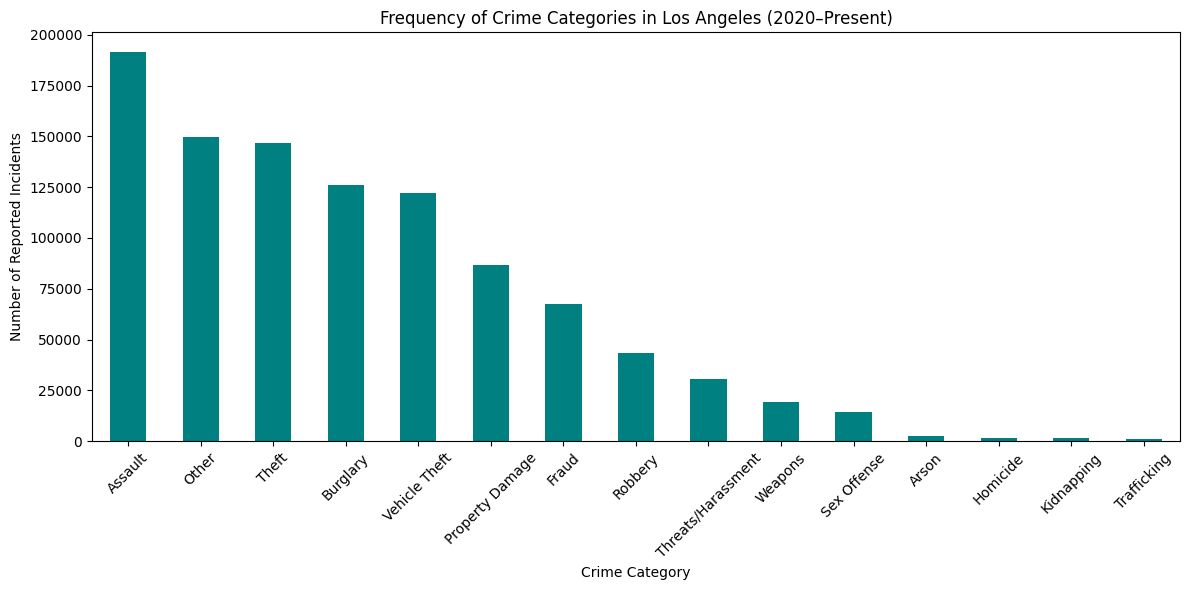

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
clean_df["Crime Category"].value_counts().plot(kind="bar", color="teal")
plt.title("Frequency of Crime Categories in Los Angeles (2020–Present)")
plt.xlabel("Crime Category")
plt.ylabel("Number of Reported Incidents")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


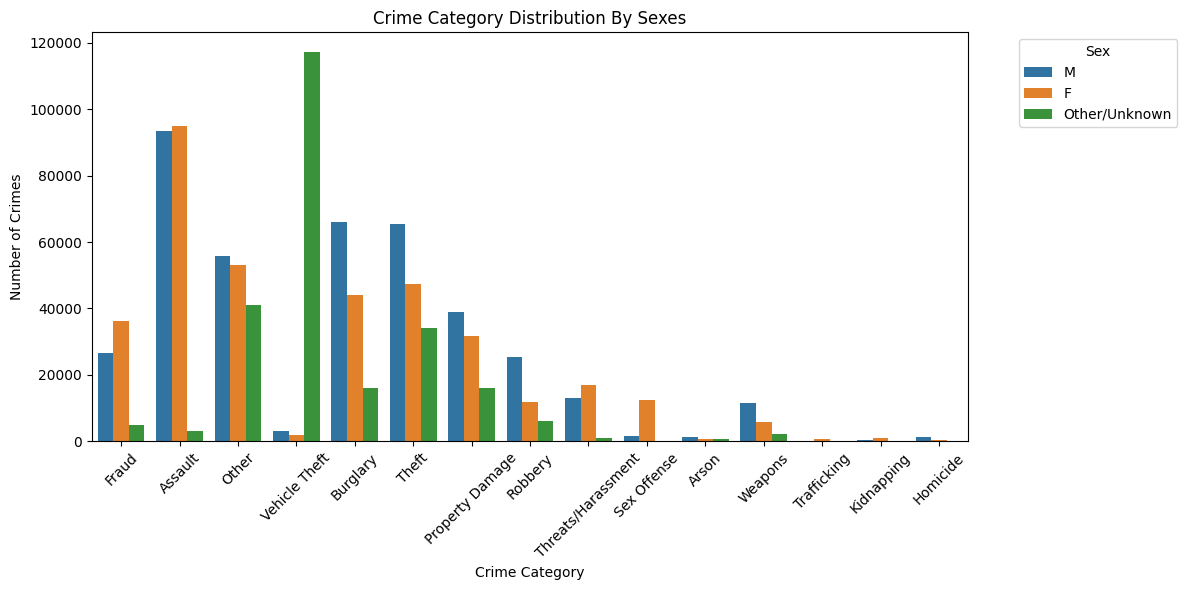

In [12]:
plt.figure(figsize=(12, 6))
sns.countplot(data=clean_df, x="Crime Category", hue="Vict Sex")
plt.title("Crime Category Distribution By Sexes")
plt.xlabel("Crime Category")
plt.ylabel("Number of Crimes")
plt.xticks(rotation=45)
plt.legend(title="Sex", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Crime Category by Time of Day

**Figure 2.** This visualization compares crime type with the time of day at which the incident occurred. **Robbery** and **Vehicle Theft** show clear spikes during the **evening and night**, while crimes like **Burglary** and **Fraud** occur more frequently during **daytime business hours**.

People are more vulnerable to robbery on streets at night, while fraud and burglary often happen during the day when financial transactions and home activity are more common. This supports using **Time Period** as a meaningful predictor in our classifier models.


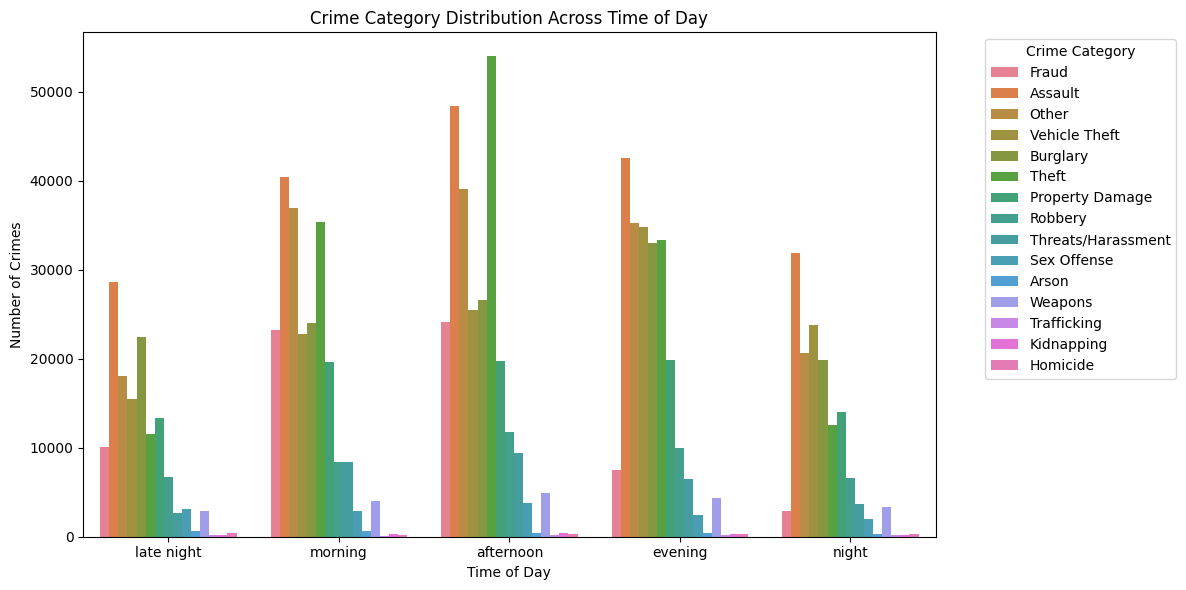

In [13]:
plt.figure(figsize=(12, 6))
sns.countplot(data=clean_df, x="Time Period", hue="Crime Category")
plt.title("Crime Category Distribution Across Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Number of Crimes")
plt.xticks(rotation=0)
plt.legend(title="Crime Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Crime Categories by Location Type

**Figure 3.** Crime type varies significantly based on where the incident takes place. For example, **Burglary** is concentrated at **residences**, **Vehicle Theft** occurs in **streets and parking areas**, and **Robbery** happens in public places such as **sidewalks, stores, and transit locations**.

Location acts as a natural indicator of how a crime occurs, meaning the attribute **Premis Desc** provides strong predictive value. This reinforces that spatial context is one of the most informative features when classifying crime into categories.


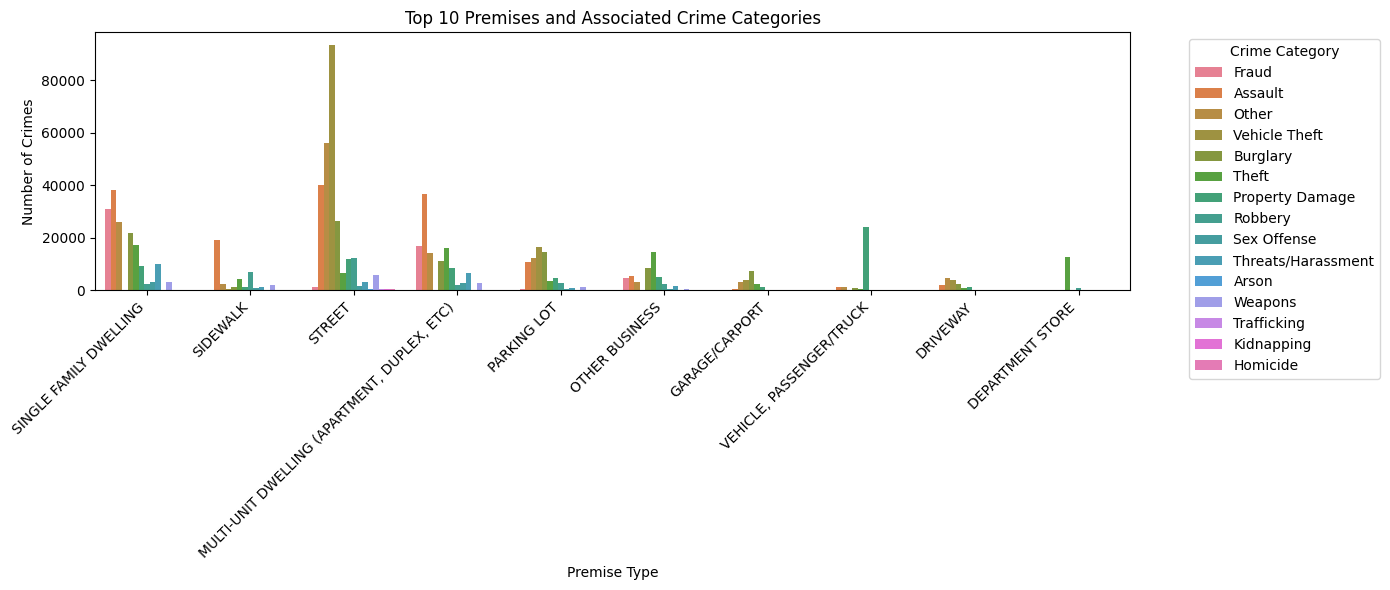

In [14]:
top_premises = clean_df["Premis Desc"].value_counts().nlargest(10).index
subset = clean_df[clean_df["Premis Desc"].isin(top_premises)]

plt.figure(figsize=(14, 6))
sns.countplot(data=subset, x="Premis Desc", hue="Crime Category")
plt.title("Top 10 Premises and Associated Crime Categories")
plt.xlabel("Premise Type")
plt.ylabel("Number of Crimes")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Crime Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [15]:
# Test categorical encoding
X_enc, y_enc, encs = build_encoded_dataset(clean_df)

print("Encoded X sample:", X_enc[:3])
print("Encoded y sample:", y_enc[:3])
print("\nEncoding maps available:", encs.keys())


Encoded X sample: [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 1, 1, 0, 1], [0, 1, 0, 0, 0, 2, 2, 1, 2]]
Encoded y sample: [0, 1, 0]

Encoding maps available: dict_keys(['Vict Sex', 'Vict Descent', 'Vict Age Group', 'Sex_Age', 'Premis Desc', 'Time Period', 'Premise_Time', 'AREA NAME', 'Area_Time', 'Crime Category'])


## Naive Bayes Classifier – Stratified Train/Test Evaluation

For classifiers in this project, we use a **stratified holdout evaluation** so that each model is trained and tested on the **same split** of the dataset. This also matches the random forest requirement of generating a stratified test set consisting of one third of the original data.

We first label-encode all categorical attributes and the crime category label. Then we create a **2/3 train, 1/3 test split** using a stratified procedure, so that the class distribution in the test set matches the overall dataset.

For Naive Bayes, we train a categorical Naive Bayes classifier with Laplace smoothing on the training set and evaluate on the held-out test set. We report:

- Overall **accuracy**
- The **confusion matrix** for all crime categories
- A **classification report** (precision, recall, F1-score, and support for each class, plus macro and weighted averages)

This same split function will be reused later for the decision tree and random forest classifiers so that we can fairly compare their performance.


In [16]:
# ================================================================
# Encode dataset + create stratified 2/3 train, 1/3 test split
# and evaluate Naive Bayes (with readable crime labels)
# ================================================================

import numpy as np
from mysklearn import myutils
from mysklearn.my_naive_bayes import MyNaiveBayesClassifier

#  Encode all categorical attributes and label 
X_encoded, y_encoded, encodings = build_encoded_dataset(clean_df)

print(f"Encoded dataset size: {len(X_encoded)} instances, {len(X_encoded[0])} features")

# Helper: stratified 2/3 train, 1/3 test split 
def make_stratified_train_test(X, y, random_state=0):
    """
    Use stratified_kfold_split with n_splits=3 to create
    a stratified 2/3 train, 1/3 test split.
    """
    folds = myutils.stratified_kfold_split(
        X, y,
        n_splits=3,
        random_state=random_state,
        shuffle=True
    )
    train_idx, test_idx = folds[0]  # fold[0] = (train_indices, test_indices)

    X_train = [X[i] for i in train_idx]
    X_test = [X[i] for i in test_idx]
    y_train = [y[i] for i in train_idx]
    y_test = [y[i] for i in test_idx]

    return X_train, X_test, y_train, y_test

# Create the split (this will be reused later for DT and RF)
X_train_nb, X_test_nb, y_train_nb, y_test_nb = make_stratified_train_test(
    X_encoded,
    y_encoded,
    random_state=0
)

print(f"Train size: {len(X_train_nb)}, Test size: {len(X_test_nb)}")

# Train + Evaluate Naive Bayes

nb_clf = MyNaiveBayesClassifier(laplace=1)
nb_clf.fit(X_train_nb, y_train_nb)
y_pred_nb = nb_clf.predict(X_test_nb)

#  Decode numeric labels -> crime category names
# encodings["Crime Category"] looks like: {"Assault": 0, "Theft": 1, ...}
inv_label_map = {v: k for k, v in encodings["Crime Category"].items()}

y_test_labels = [inv_label_map[i] for i in y_test_nb]
y_pred_labels = [inv_label_map[i] for i in y_pred_nb]

labels_nb = sorted(set(y_test_labels))

# Metrics 
acc_nb = myutils.accuracy_score(y_test_labels, y_pred_labels)
cm_nb = myutils.confusion_matrix(y_test_labels, y_pred_labels, labels_nb)
report_nb = myutils.classification_report(y_test_labels, y_pred_labels, labels=labels_nb)

print(f"\nNaive Bayes Accuracy: {acc_nb:.3f}\n")

print("Naive Bayes Confusion Matrix")
print("(rows = true crime category, cols = predicted crime category)")
print("Label order:", labels_nb)
print(np.array(cm_nb))

print("\nNaive Bayes Classification Report:")
print(report_nb)


Encoded dataset size: 1004991 instances, 9 features
Train size: 669999, Test size: 334992

Naive Bayes Accuracy: 0.444

Naive Bayes Confusion Matrix
(rows = true crime category, cols = predicted crime category)
Label order: ['Arson', 'Assault', 'Burglary', 'Fraud', 'Homicide', 'Kidnapping', 'Other', 'Property Damage', 'Robbery', 'Sex Offense', 'Theft', 'Threats/Harassment', 'Trafficking', 'Vehicle Theft', 'Weapons']
[[   48   186    96    83     0     0    97    80    35     5   177     1
      2    45     1]
 [   77 34263  5437 10209   170    75  3632   664  2215  2200  3802   427
    299   364    43]
 [  377  9043 16504  5879    38    18  2721  1286   307   221  5031   190
     23   373     4]
 [   22  3766  1092 14118     9     8   514    86    92   183  2106   187
      2   382     0]
 [    1   355    41    31     7     0    24     9    34     4    17     1
      0     0     1]
 [    2   220    28    42     0     1    60    11    14    50    11     2
     17     2     1]
 [  288 11

### 📌 Naive Bayes Classification Results

Naive Bayes was our first classifier applied to the LAPD dataset. After preprocessing, all features were categorical (victim demographics, location, premise type, and time period). Because Naive Bayes assumes **conditional independence between features**, it provides a useful baseline but is not expected to capture complex correlations present in real crime data.

To improve performance, we engineered additional contextual features such as:

- **Premise + Time Period**
- **Age Group + Sex**
- **Premise Risk Encoding** (e.g., residential vs. public vs. commercial)

These combinations aim to capture meaningful real-world relationships (for example, *vehicle theft occurring at night*, or *assault occurring more often in public areas with young adult victims*).  

However, Naive Bayes still performed poorly relative to the scale and complexity of the dataset. Several factors explain its limitations:

- **Feature Correlation:** Many features are strongly related (e.g., premise and time period), but Naive Bayes treats them as independent, leading to overconfident misclassification.
- **Severe Class Imbalance:** Rare crimes (e.g., *Kidnapping*, *Homicide*, *Arson*) lack enough examples for reliable probability estimates, even after smoothing.
- **High Noise in Premise Descriptions:** Some premises overlap heavily in meaning (e.g., “alley,” “driveway,” “parking lot”), which reduces signal clarity for a probability-based model.

> **Conclusion:** Although Naive Bayes captured some meaningful trends after feature engineering, it struggled to model the complex, highly correlated nature of crime data. Its performance establishes a useful baseline, but more expressive models (such as decision trees and random forests) are better suited for this classification task.
